In [ ]:
# Install dependencies
!pip install datasets transformers torch scikit-learn numpy pandas tqdm joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 71.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import time
import joblib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the dair-ai/emotion dataset
ds = load_dataset("dair-ai/emotion", "split")

# Print dataset info
print("Dataset info:")
print(f"Train samples: {len(ds['train'])}")
print(f"Validation samples: {len(ds['validation'])}")
print(f"Test samples: {len(ds['test'])}")

# Get the emotion labels
labels = ds["train"].features["label"].names
num_labels = len(labels)
print(f"Number of emotion labels: {num_labels}")
print(f"Labels: {labels}")

# Display a few examples
print("\nSample examples:")
for i in range(3):
    print(f"Text: {ds['train'][i]['text']}")
    print(f"Label: {labels[ds['train'][i]['label']]}")
    print()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/9.05k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset info:
Train samples: 16000
Validation samples: 2000
Test samples: 2000
Number of emotion labels: 6
Labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

Sample examples:
Text: i didnt feel humiliated
Label: sadness

Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Label: sadness

Text: im grabbing a minute to post i feel greedy wrong
Label: anger



In [ ]:
class EmotionDataset(Dataset):
    """Dataset class for Emotion dataset"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Squeeze to remove batch dimension added by tokenizer
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)  # Long tensor for classification
        }

In [ ]:
def load_and_preprocess():
    """Load and preprocess the dair-ai/emotion dataset"""
    start_time = time.time()
    print("Loading dataset...")

    # Load emotion dataset
    ds = load_dataset("dair-ai/emotion", "split")

    # Get labels
    labels = ds["train"].features["label"].names
    num_labels = len(labels)

    # Extract texts and labels
    train_texts = ds["train"]["text"]
    train_labels = ds["train"]["label"]

    val_texts = ds["validation"]["text"]
    val_labels = ds["validation"]["label"]

    test_texts = ds["test"]["text"]
    test_labels = ds["test"]["label"]

    print(f"Dataset loaded and preprocessed in {time.time() - start_time:.2f} seconds")
    print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}, Test samples: {len(test_texts)}")
    print(f"Number of emotion classes: {num_labels}")

    return train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, labels

In [ ]:
def create_dataloaders(train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, tokenizer, batch_size=16):
    """Create DataLoader objects for training and evaluation"""
    start_time = time.time()
    print("Creating dataloaders...")

    # Create datasets
    train_dataset = EmotionDataset(train_texts, train_labels, tokenizer)
    val_dataset = EmotionDataset(val_texts, val_labels, tokenizer)
    test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)

    # Create dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

    print(f"Dataloaders created in {time.time() - start_time:.2f} seconds")

    return train_dataloader, val_dataloader, test_dataloader

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, epoch):
    """Train model for one epoch"""
    model.train()
    total_loss = 0

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch}")
    for batch in progress_bar:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({"loss": f"{loss.item():.4f}"})

    return total_loss / len(dataloader)


def evaluate(model, dataloader):
    """Evaluate model on validation or test data"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_preds), np.array(all_labels)

In [ ]:
def train_model(train_dataloader, val_dataloader, test_dataloader, num_labels, epochs=4):
    """Train RoBERTa model for emotion classification"""
    # Initialize model
    model_name = "roberta-base"
    model = RobertaForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    model.to(device)

    # Training parameters
    optimizer = AdamW(model.parameters(), lr=2e-5)
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    best_accuracy = 0
    best_model = None

    start_time = time.time()
    print(f"Starting training for {epochs} epochs...")

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()

        # Train
        train_loss = train_epoch(model, train_dataloader, optimizer, scheduler, epoch)

        # Validate
        val_preds, val_labels = evaluate(model, val_dataloader)

        # Calculate metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_f1 = f1_score(val_labels, val_preds, average="weighted")

        epoch_time = time.time() - epoch_start

        print(f"Epoch {epoch}: Train Loss = {train_loss:.4f}, Val Accuracy = {val_accuracy:.4f}, "
              f"Val Weighted-F1 = {val_f1:.4f}, Time = {epoch_time:.2f}s")

        # Save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model.state_dict().copy()
            print(f"New best model with Accuracy = {val_accuracy:.4f}")

    total_time = time.time() - start_time
    print(f"Training completed in {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

    # Load best model for final evaluation
    model.load_state_dict(best_model)

    # Evaluate on test set
    print("Evaluating on test set...")
    test_preds, test_labels = evaluate(model, test_dataloader)

    test_accuracy = accuracy_score(test_labels, test_preds)
    test_f1 = f1_score(test_labels, test_preds, average="weighted")

    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Weighted-F1: {test_f1:.4f}")

    # Show detailed classification report
    print("\nClassification Report:")
    print(classification_report(test_labels, test_preds, target_names=labels))

    return model

In [ ]:
def save_model(model, tokenizer, emotion_labels, model_dir="roberta_emotion_model"):
    """Save the trained model and components"""
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Save model and tokenizer
    model.save_pretrained(os.path.join(model_dir, "model"))
    tokenizer.save_pretrained(os.path.join(model_dir, "tokenizer"))

    # Save emotion labels
    joblib.dump(emotion_labels, os.path.join(model_dir, "emotion_labels.joblib"))

    # Save model info
    model_info = {
        "model_type": "roberta-base",
        "num_labels": len(emotion_labels),
        "problem_type": "single_label_classification",
        "labels": emotion_labels
    }
    joblib.dump(model_info, os.path.join(model_dir, "model_info.joblib"))

    print(f"Model and components saved to {model_dir}/")


def predict_sample(text, model, tokenizer, emotion_labels):
    """Test prediction on a sample text"""
    model.eval()

    # Tokenize
    inputs = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Move to device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        pred = torch.argmax(logits, dim=1).item()

    # Get predicted emotion
    predicted_emotion = emotion_labels[pred]

    return predicted_emotion

In [ ]:
def main():
    """Main function to train and save RoBERTa model"""
    # Start timer for the whole process
    total_start_time = time.time()

    # Load and preprocess data
    train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, emotion_labels = load_and_preprocess()

    # Initialize tokenizer
    print("Loading RoBERTa tokenizer...")
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

    # Create dataloaders
    batch_size = 16  # Adjust based on available GPU memory
    train_dataloader, val_dataloader, test_dataloader = create_dataloaders(
        train_texts, train_labels, val_texts, val_labels, test_texts, test_labels, tokenizer, batch_size
    )

    # Train model
    model = train_model(
        train_dataloader, val_dataloader, test_dataloader, num_labels=len(emotion_labels), epochs=4
    )

    # Save model and components
    save_model(model, tokenizer, emotion_labels, model_dir="roberta_emotion_model")

    # Test on sample
    print("\nTesting model on sample texts:")
    samples = [
        "I'm so happy today! Everything is going great.",
        "This makes me angry and frustrated.",
        "I'm not sure how to feel about this news."
    ]

    for sample in samples:
        emotion = predict_sample(sample, model, tokenizer, emotion_labels)
        print(f"\nText: {sample}")
        print(f"Predicted emotion: {emotion}")

    # Print total time
    total_time = time.time() - total_start_time
    print(f"\nTotal execution time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

    # Print expected run time for future runs
    print("\nExpected run times for future training:")
    print(f"Dataset loading: ~{(time.time() - total_start_time) / 60:.1f} minutes")
    print(f"Training (4 epochs): ~{total_time / 60:.1f} minutes on {device}")
    print("Note: Times will vary based on hardware, especially if using GPU vs CPU")


if __name__ == "__main__":
    main()

Loading dataset...
Dataset loaded and preprocessed in 1.74 seconds
Train samples: 16000, Validation samples: 2000, Test samples: 2000
Number of emotion classes: 6
Loading RoBERTa tokenizer...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Creating dataloaders...
Dataloaders created in 0.00 seconds


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training for 4 epochs...


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.69it/s]


Epoch 1: Train Loss = 0.5114, Val Accuracy = 0.9275, Val Weighted-F1 = 0.9279, Time = 360.77s
New best model with Accuracy = 0.9275


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.65it/s]


Epoch 2: Train Loss = 0.1943, Val Accuracy = 0.9325, Val Weighted-F1 = 0.9312, Time = 362.67s
New best model with Accuracy = 0.9325


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.67it/s]


Epoch 3: Train Loss = 0.1327, Val Accuracy = 0.9320, Val Weighted-F1 = 0.9315, Time = 362.74s


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.69it/s]


Epoch 4: Train Loss = 0.1005, Val Accuracy = 0.9385, Val Weighted-F1 = 0.9384, Time = 362.71s
New best model with Accuracy = 0.9385
Training completed in 1448.90 seconds (24.15 minutes)
Evaluating on test set...


Evaluating: 100%|██████████| 125/125 [00:12<00:00,  9.65it/s]


Test Accuracy: 0.9340
Test Weighted-F1: 0.9337

Classification Report:
              precision    recall  f1-score   support

     sadness       0.96      0.97      0.96       581
         joy       0.96      0.96      0.96       695
        love       0.85      0.91      0.88       159
       anger       0.91      0.93      0.92       275
        fear       0.93      0.86      0.89       224
    surprise       0.78      0.71      0.75        66

    accuracy                           0.93      2000
   macro avg       0.90      0.89      0.89      2000
weighted avg       0.93      0.93      0.93      2000

Model and components saved to roberta_emotion_model/

Testing model on sample texts:

Text: I'm so happy today! Everything is going great.
Predicted emotion: joy

Text: This makes me angry and frustrated.
Predicted emotion: anger

Text: I'm not sure how to feel about this news.
Predicted emotion: joy

Total execution time: 1477.26 seconds (24.62 minutes)

Expected run times for futur

In [ ]:
import os
import shutil

# Specify the model directory
model_dir = "roberta_emotion_model"

# Create a zip file of the model directory
shutil.make_archive(model_dir, 'zip', model_dir)

# Download the zip file
from google.colab import files
files.download(f"{model_dir}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Interactive emotion prediction cell
import torch
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import joblib
from IPython.display import display, HTML
import ipywidgets as widgets

# Load the model, tokenizer and labels
model_dir = "roberta_emotion_model"
model = RobertaForSequenceClassification.from_pretrained(f"{model_dir}/model")
tokenizer = RobertaTokenizer.from_pretrained(f"{model_dir}/tokenizer")
emotion_labels = joblib.load(f"{model_dir}/emotion_labels.joblib")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_emotion(text):
    """Predict emotion for a given text"""
    # Set model to evaluation mode
    model.eval()

    # Tokenize
    inputs = tokenizer(
        text,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )

    # Move to device
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Get probabilities
        probs = torch.nn.functional.softmax(logits, dim=1)

        # Get top 3 predictions
        values, indices = torch.topk(probs, k=3)

        # Create results
        results = []
        for i in range(3):
            emotion = emotion_labels[indices[0][i].item()]
            probability = values[0][i].item() * 100  # Convert to percentage
            results.append((emotion, probability))

    return results

# Create interactive widgets
text_input = widgets.Text(
    value='',
    placeholder='Type a sentence to analyze...',
    description='Text:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='80%')
)

output = widgets.Output()

def on_text_submitted(sender):
    """Handle text submission"""
    with output:
        output.clear_output()
        print(f"Analyzing: \"{text_input.value}\"")
        if text_input.value.strip() == "":
            print("Please enter a sentence to analyze.")
            return

        # Get prediction
        results = predict_emotion(text_input.value)

        # Display results
        print("\nPredicted Emotions:")
        for emotion, probability in results:
            print(f"  {emotion}: {probability:.2f}%")

# Connect the callback function to the text input
text_input.on_submit(on_text_submitted)

# Create a button for submission
button = widgets.Button(
    description='Analyze Emotion',
    disabled=False,
    button_style='',
    tooltip='Click to analyze the text',
    icon='check'
)

def on_button_click(b):
    """Handle button click"""
    on_text_submitted(text_input)

button.on_click(on_button_click)

# Display the widgets
print("Enter a sentence and press Enter or click the button to analyze its emotion:")
display(text_input, button, output)

Enter a sentence and press Enter or click the button to analyze its emotion:


Text(value='', description='Text:', layout=Layout(width='80%'), placeholder='Type a sentence to analyze...', s…

Button(description='Analyze Emotion', icon='check', style=ButtonStyle(), tooltip='Click to analyze the text')

Output()

# Analysis

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score
)
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import joblib
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load model and tokenizer
model_dir = "roberta_emotion_model"
model = RobertaForSequenceClassification.from_pretrained(f"{model_dir}/model")
tokenizer = RobertaTokenizer.from_pretrained(f"{model_dir}/tokenizer")
emotion_labels = joblib.load(f"{model_dir}/emotion_labels.joblib")

# Move model to device
model.to(device)

# Load test dataset
test_ds = load_dataset("dair-ai/emotion", "split", split="test")

# Create output directory for analysis
analysis_dir = "model_analysis"
if not os.path.exists(analysis_dir):
    os.makedirs(analysis_dir)

print(f"Model loaded. Number of emotion classes: {len(emotion_labels)}")
print(f"Test dataset size: {len(test_ds)}")
print(f"Emotion labels: {emotion_labels}")

Using device: cuda
Model loaded. Number of emotion classes: 6
Test dataset size: 2000
Emotion labels: ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']


In [ ]:
class EmotionDataset(Dataset):
    """Dataset class for Emotion dataset"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Squeeze to remove batch dimension added by tokenizer
        input_ids = encoding["input_ids"].squeeze()
        attention_mask = encoding["attention_mask"].squeeze()

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long),
            "text": text  # Include original text for analysis
        }

# Create test dataset and dataloader
test_texts = test_ds["text"]
test_labels = test_ds["label"]

test_dataset = EmotionDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=32)

print("Test dataloader created.")

Test dataloader created.


In [ ]:
def get_all_predictions(model, dataloader):
    """Get predictions for all examples in the dataloader"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    all_texts = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)
            texts = batch["text"]

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_texts.extend(texts)

    return np.array(all_preds), np.array(all_labels), np.array(all_probs), all_texts

# Get predictions
print("Getting predictions for all test examples...")
predictions, true_labels, probabilities, texts = get_all_predictions(model, test_dataloader)

# Save for later analysis
np.save(f"{analysis_dir}/predictions.npy", predictions)
np.save(f"{analysis_dir}/true_labels.npy", true_labels)
np.save(f"{analysis_dir}/probabilities.npy", probabilities)
with open(f"{analysis_dir}/texts.txt", 'w', encoding='utf-8') as f:
    for text in texts:
        f.write(text + '\n')

print(f"Predictions saved to {analysis_dir}/")

Getting predictions for all test examples...


Getting predictions:   0%|          | 0/63 [00:00<?, ?it/s]

Predictions saved to model_analysis/


In [ ]:
# Classification report
report = classification_report(
    true_labels,
    predictions,
    target_names=emotion_labels,
    output_dict=True
)

# Convert to DataFrame for better visualization
report_df = pd.DataFrame(report).transpose()

# Print and save report
print("Classification Report:")
print(report_df.round(3))
report_df.to_csv(f"{analysis_dir}/classification_report.csv")

# Overall accuracy
accuracy = report_df.loc['accuracy', 'f1-score']
print(f"\nOverall Accuracy: {accuracy:.4f}")

# Per-class metrics
plt.figure(figsize=(15, 10))
metrics_df = report_df.loc[emotion_labels, ['precision', 'recall', 'f1-score']]
metrics_df.plot(kind='bar', figsize=(15, 6))
plt.title('Precision, Recall, and F1-score by Emotion')
plt.ylabel('Score')
plt.xlabel('Emotion')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{analysis_dir}/per_class_metrics.png")
plt.close()

Classification Report:
              precision  recall  f1-score   support
sadness           0.956   0.967     0.962   581.000
joy               0.961   0.955     0.958   695.000
love              0.848   0.912     0.879   159.000
anger             0.911   0.935     0.923   275.000
fear              0.928   0.862     0.894   224.000
surprise          0.783   0.712     0.746    66.000
accuracy          0.934   0.934     0.934     0.934
macro avg         0.898   0.890     0.893  2000.000
weighted avg      0.934   0.934     0.934  2000.000

Overall Accuracy: 0.9340


<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    xticklabels=emotion_labels,
    yticklabels=emotion_labels
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig(f"{analysis_dir}/confusion_matrix.png")
plt.close()

# Identify most confused pairs
confusion_pairs = []
np.fill_diagonal(cm, 0)  # Remove correct predictions
for i in range(len(emotion_labels)):
    for j in range(len(emotion_labels)):
        if cm[i, j] > 0:
            confusion_pairs.append({
                'true': emotion_labels[i],
                'predicted': emotion_labels[j],
                'count': cm[i, j],
                'percent': cm[i, j] / np.sum(cm[i, :] + cm[:, i]) * 100
            })

# Sort by count and show top confusions
confusion_df = pd.DataFrame(confusion_pairs)
confusion_df = confusion_df.sort_values('count', ascending=False)
print("Top 10 most confused pairs:")
print(confusion_df.head(10))
confusion_df.to_csv(f"{analysis_dir}/confusion_pairs.csv", index=False)

Top 10 most confused pairs:
        true predicted  count    percent
4        joy      love     26  44.827586
6       love       joy     14  35.000000
1    sadness     anger     13  28.888889
7      anger   sadness     13  30.232558
12      fear  surprise     13  28.260870
11      fear     anger     10  21.739130
15  surprise      fear     10  31.250000
10      fear   sadness      8  17.391304
14  surprise       joy      7  21.875000
0    sadness       joy      3   6.666667


In [ ]:
# Analyze prediction confidence by correctness
correct_mask = predictions == true_labels
confidence = np.max(probabilities, axis=1)

correct_confidence = confidence[correct_mask]
incorrect_confidence = confidence[~correct_mask]

# Plot confidence distributions
plt.figure(figsize=(10, 6))
sns.histplot(correct_confidence, color='green', alpha=0.5, label='Correct Predictions')
sns.histplot(incorrect_confidence, color='red', alpha=0.5, label='Incorrect Predictions')
plt.xlabel('Confidence (Max Probability)')
plt.ylabel('Count')
plt.title('Confidence Distribution for Correct vs. Incorrect Predictions')
plt.legend()
plt.tight_layout()
plt.savefig(f"{analysis_dir}/confidence_distribution.png")
plt.close()

# Confidence thresholds analysis
thresholds = np.arange(0.1, 1.0, 0.05)
coverage = []
accuracy_at_threshold = []

for threshold in thresholds:
    # Examples where confidence is at least the threshold
    mask = confidence >= threshold

    # Coverage = percentage of examples that meet the threshold
    cov = np.mean(mask) * 100
    coverage.append(cov)

    # Accuracy for examples that meet the threshold
    if np.sum(mask) > 0:
        acc = np.mean(correct_mask[mask]) * 100
    else:
        acc = 0
    accuracy_at_threshold.append(acc)

# Plot accuracy vs coverage at different thresholds
plt.figure(figsize=(10, 6))
plt.plot(thresholds, accuracy_at_threshold, marker='o', linestyle='-', linewidth=2)
plt.xlabel('Confidence Threshold')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy at Different Confidence Thresholds')
for i, threshold in enumerate(thresholds):
    plt.annotate(f"{coverage[i]:.1f}%",
                 (threshold, accuracy_at_threshold[i]),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')
plt.tight_layout()
plt.savefig(f"{analysis_dir}/accuracy_vs_threshold.png")
plt.close()

print("Confidence analysis completed and saved.")

Confidence analysis completed and saved.


In [ ]:
# Prepare ROC and PR curves
plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotion_labels):
    # One-vs-rest strategy (emotion vs not emotion)
    y_true_binary = (true_labels == i).astype(int)
    y_scores = probabilities[:, i]

    # ROC curve
    fpr, tpr, _ = roc_curve(y_true_binary, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f'{emotion} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Emotion')
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig(f"{analysis_dir}/roc_curves.png")
plt.close()

# Precision-Recall curves
plt.figure(figsize=(15, 10))
for i, emotion in enumerate(emotion_labels):
    y_true_binary = (true_labels == i).astype(int)
    y_scores = probabilities[:, i]

    precision, recall, _ = precision_recall_curve(y_true_binary, y_scores)
    avg_precision = average_precision_score(y_true_binary, y_scores)

    plt.plot(recall, precision, lw=2, label=f'{emotion} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Each Emotion')
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(f"{analysis_dir}/precision_recall_curves.png")
plt.close()

# Create AUC and AP DataFrame
curve_metrics = []
for i, emotion in enumerate(emotion_labels):
    y_true_binary = (true_labels == i).astype(int)
    y_scores = probabilities[:, i]

    # ROC AUC
    roc_auc = roc_curve(y_true_binary, y_scores)[2]

    # Average Precision
    avg_precision = average_precision_score(y_true_binary, y_scores)

    curve_metrics.append({
        'emotion': emotion,
        'ROC_AUC': roc_auc,
        'Average_Precision': avg_precision
    })

curve_df = pd.DataFrame(curve_metrics)
print("ROC and PR curves analysis:")
print(curve_df)
curve_df.to_csv(f"{analysis_dir}/curve_metrics.csv", index=False)

ROC and PR curves analysis:
    emotion                                            ROC_AUC  \
0   sadness  [inf, 0.9995902, 0.9995814, 0.9995809, 0.99958...   
1       joy  [inf, 0.9994198, 0.9994197, 0.99941933, 0.9994...   
2      love  [inf, 0.99835074, 0.99825996, 0.998259, 0.9982...   
3     anger  [inf, 0.99923325, 0.99920386, 0.9992034, 0.999...   
4      fear  [inf, 0.9989717, 0.99894506, 0.9989448, 0.9989...   
5  surprise  [inf, 0.9976472, 0.9960019, 0.7634792, 0.63012...   

   Average_Precision  
0           0.995696  
1           0.994118  
2           0.952162  
3           0.988371  
4           0.976989  
5           0.877381  


In [ ]:
# Create DataFrame for error analysis
results_df = pd.DataFrame({
    'text': texts,
    'true_label': [emotion_labels[label] for label in true_labels],
    'predicted_label': [emotion_labels[pred] for pred in predictions],
    'confidence': np.max(probabilities, axis=1),
    'correct': true_labels == predictions
})

# Find errors
errors_df = results_df[~results_df['correct']]

# Group errors by true and predicted labels
error_counts = errors_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')
error_counts = error_counts.sort_values('count', ascending=False)

print("Most common error types:")
print(error_counts.head(10))
error_counts.to_csv(f"{analysis_dir}/error_counts.csv", index=False)

# Find examples of the most common errors
top_error_types = error_counts.head(5)
error_examples = []

for _, row in top_error_types.iterrows():
    true_label = row['true_label']
    pred_label = row['predicted_label']

    # Find examples of this error type
    examples = errors_df[
        (errors_df['true_label'] == true_label) &
        (errors_df['predicted_label'] == pred_label)
    ].sort_values('confidence', ascending=False).head(3)

    for _, example in examples.iterrows():
        error_examples.append({
            'error_type': f"{true_label} → {pred_label}",
            'text': example['text'],
            'confidence': example['confidence']
        })

error_examples_df = pd.DataFrame(error_examples)
print("\nExamples of common errors:")
for i, row in error_examples_df.iterrows():
    print(f"\nError type: {row['error_type']}")
    print(f"Text: {row['text']}")
    print(f"Confidence: {row['confidence']:.4f}")

error_examples_df.to_csv(f"{analysis_dir}/error_examples.csv", index=False)

# Low confidence correct predictions
low_confidence_correct = results_df[
    (results_df['correct']) &
    (results_df['confidence'] < 0.8)
].sort_values('confidence')

print("\nLow confidence correct predictions:")
print(low_confidence_correct.head(5)[['text', 'true_label', 'confidence']])

# High confidence incorrect predictions
high_confidence_incorrect = errors_df[
    errors_df['confidence'] > 0.9
].sort_values('confidence', ascending=False)

print("\nHigh confidence incorrect predictions:")
print(high_confidence_incorrect.head(5)[['text', 'true_label', 'predicted_label', 'confidence']])

# Save detailed results
results_df.to_csv(f"{analysis_dir}/all_predictions.csv", index=False)

Most common error types:
   true_label predicted_label  count
7         joy            love     26
9        love             joy     14
5        fear        surprise     13
2       anger         sadness     13
10    sadness           anger     13
13   surprise            fear     10
3        fear           anger     10
4        fear         sadness      8
14   surprise             joy      7
11    sadness            fear      3

Examples of common errors:

Error type: joy → love
Text: ive come to feel about a supporting character in one of my all time favorite films giant
Confidence: 0.9982

Error type: joy → love
Text: i grew up around this feeling living only minutes away from the gorgeous atlantic ocean in brazil so its probably no surprise i grew fond of the ocean
Confidence: 0.9891

Error type: joy → love
Text: i never feel like im not supporting
Confidence: 0.9884

Error type: love → joy
Text: i feel affirmed gracious sensuous and will have less self doubt when a href http genera

In [ ]:
# Modified Edge Cases Analysis
def find_edge_cases(df, emotion_labels):
    """Find edge cases in model predictions"""
    # First add text analysis columns
    print("Adding text analysis columns...")

    # Add word count
    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    print(f"Word count column added. Range: {df['word_count'].min()} to {df['word_count'].max()} words")

    # Add text length
    df['text_length'] = df['text'].apply(len)
    print(f"Text length column added. Range: {df['text_length'].min()} to {df['text_length'].max()} characters")

    # Most ambiguous predictions (where top two class probabilities are close)
    print("Calculating probability differences...")
    top2_diffs = []
    for i in range(len(probabilities)):
        sorted_probs = np.sort(probabilities[i])[::-1]
        top2_diff = sorted_probs[0] - sorted_probs[1]
        top2_diffs.append(top2_diff)

    df['top2_diff'] = top2_diffs
    ambiguous = df.sort_values('top2_diff').head(20)

    print("Most ambiguous predictions (smallest difference between top 2 classes):")
    for _, row in ambiguous.head(5).iterrows():
        print(f"Text: {row['text']}")
        print(f"True: {row['true_label']}, Predicted: {row['predicted_label']}, Confidence: {row['confidence']:.4f}")
        print(f"Difference between top 2 probabilities: {row['top2_diff']:.4f}")
        print()

    # Very short texts with correct predictions
    short_correct = df[(df['word_count'] <= 3) & df['correct']].sort_values('word_count')

    print("Short texts with correct predictions:")
    if len(short_correct) > 0:
        for _, row in short_correct.head(5).iterrows():
            print(f"Text: {row['text']}")
            print(f"True/Predicted: {row['true_label']}, Confidence: {row['confidence']:.4f}")
            print()
    else:
        print("No short correct texts found with <= 3 words.")

    # Very short texts with incorrect predictions
    short_incorrect = df[(df['word_count'] <= 3) & ~df['correct']].sort_values('word_count')

    print("Short texts with incorrect predictions:")
    if len(short_incorrect) > 0:
        for _, row in short_incorrect.head(5).iterrows():
            print(f"Text: {row['text']}")
            print(f"True: {row['true_label']}, Predicted: {row['predicted_label']}, Confidence: {row['confidence']:.4f}")
            print()
    else:
        print("No short incorrect texts found with <= 3 words.")

    # Check for negations
    print("Analyzing texts with negation...")
    negation_words = ['not', "n't", 'never', 'no']
    df['contains_negation'] = df['text'].apply(
        lambda x: any(neg in str(x).lower().split() for neg in negation_words)
    )

    negation_accuracy = df.groupby('contains_negation')['correct'].mean()

    print("Accuracy with and without negation:")
    print(negation_accuracy)

    # Examples of negation errors
    negation_errors = df[(df['contains_negation']) & (~df['correct'])].head(10)

    print("\nErrors with negation:")
    if len(negation_errors) > 0:
        for _, row in negation_errors.head(5).iterrows():
            print(f"Text: {row['text']}")
            print(f"True: {row['true_label']}, Predicted: {row['predicted_label']}, Confidence: {row['confidence']:.4f}")
            print()
    else:
        print("No errors with negation found.")

    # Get a safe list of edge cases to return
    return {
        'ambiguous': ambiguous if len(ambiguous) > 0 else pd.DataFrame(columns=df.columns),
        'short_correct': short_correct if len(short_correct) > 0 else pd.DataFrame(columns=df.columns),
        'short_incorrect': short_incorrect if len(short_incorrect) > 0 else pd.DataFrame(columns=df.columns),
        'negation_errors': negation_errors if len(negation_errors) > 0 else pd.DataFrame(columns=df.columns)
    }

# Find edge cases
edge_cases = find_edge_cases(results_df, emotion_labels)

# Save edge cases
for name, df in edge_cases.items():
    if not df.empty:
        df.to_csv(f"{analysis_dir}/{name}_cases.csv", index=False)
        print(f"Saved {len(df)} examples to {name}_cases.csv")
    else:
        print(f"No examples found for {name}_cases.csv")

Adding text analysis columns...
Word count column added. Range: 3 to 61 words
Text length column added. Range: 14 to 296 characters
Calculating probability differences...
Most ambiguous predictions (smallest difference between top 2 classes):
Text: i feel all weird when i have to meet w people i text but like dont talk face to face w
True: fear, Predicted: fear, Confidence: 0.5027
Difference between top 2 probabilities: 0.0118

Text: i received the blanket i was absolutely amazed on how fluffy it is and extremely soft i really didnt think it was going to feel that amazing
True: surprise, Predicted: surprise, Confidence: 0.5006
Difference between top 2 probabilities: 0.0121

Text: i feel like that im hated by most of the girls is it becoz im a good dancer
True: sadness, Predicted: sadness, Confidence: 0.5050
Difference between top 2 probabilities: 0.0125

Text: i feel so weird and scattered with all wonders about a million different things
True: surprise, Predicted: surprise, Confidence

In [ ]:
# Modified Emotion Clustering Analysis
print("Analyzing emotion similarities and clusters...")

# Create a confusion matrix based on how often emotions are confused
cm_df = pd.DataFrame(cm, index=emotion_labels, columns=emotion_labels)

# Plot the raw confusion matrix first
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, fmt='.0f', cmap='Blues')
plt.title('Raw Confusion Matrix')
plt.tight_layout()
plt.savefig(f"{analysis_dir}/raw_confusion_matrix.png")
plt.close()

# Convert to correlation-like matrix
# Normalize by dividing by the sum of each row
row_sums = cm_df.sum(axis=1)
normalized_cm = cm_df.div(row_sums, axis=0)

# Plot as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(normalized_cm, annot=True, fmt='.2f', cmap='Blues')
plt.title('Emotion Confusion Correlations')
plt.tight_layout()
plt.savefig(f"{analysis_dir}/emotion_correlations.png")
plt.close()

# Try to cluster emotions based on confusions
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform

try:
    # Method 1: Create a symmetric distance matrix
    # We'll use the average of confusion from A to B and B to A
    symmetric_matrix = (normalized_cm + normalized_cm.T) / 2

    # Convert to distance matrix (1 - normalized_cm)
    distance_matrix = 1 - symmetric_matrix
    np.fill_diagonal(distance_matrix.values, 0)  # Set diagonal to 0

    # Verify symmetry
    if not np.allclose(distance_matrix, distance_matrix.T):
        print("Warning: Distance matrix is not perfectly symmetric. Forcing symmetry.")
        distance_matrix = (distance_matrix + distance_matrix.T) / 2

    # Convert to condensed distance matrix
    condensed_dist = squareform(distance_matrix)

    # Perform hierarchical clustering
    linkage = hierarchy.linkage(condensed_dist, method='average')

    # Plot dendrogram
    plt.figure(figsize=(12, 8))
    hierarchy.dendrogram(
        linkage,
        labels=emotion_labels,
        leaf_rotation=90
    )
    plt.title('Hierarchical Clustering of Emotions Based on Confusion Patterns')
    plt.tight_layout()
    plt.savefig(f"{analysis_dir}/emotion_clusters.png")
    plt.close()

    print("Hierarchical clustering completed successfully.")
except Exception as e:
    # Alternative method if the first one fails
    print(f"Error in hierarchical clustering: {e}")
    print("Trying alternative clustering method...")

    try:
        # Use a different approach: convert raw data to pairwise distances
        # Create a feature matrix where each emotion is represented by its confusion pattern
        features = normalized_cm.values

        # Compute pairwise distances directly
        distances = pdist(features, metric='euclidean')

        # Perform hierarchical clustering on these distances
        linkage = hierarchy.linkage(distances, method='average')

        # Plot dendrogram
        plt.figure(figsize=(12, 8))
        hierarchy.dendrogram(
            linkage,
            labels=emotion_labels,
            leaf_rotation=90
        )
        plt.title('Hierarchical Clustering of Emotions (Alternative Method)')
        plt.tight_layout()
        plt.savefig(f"{analysis_dir}/emotion_clusters_alt.png")
        plt.close()

        print("Alternative hierarchical clustering completed successfully.")
    except Exception as e2:
        print(f"Alternative clustering also failed: {e2}")
        print("Skipping clustering visualization.")

print("Emotion similarity analysis completed.")

Analyzing emotion similarities and clusters...
Hierarchical clustering completed successfully.
Emotion similarity analysis completed.


In [ ]:
def analyze_errors_by_pattern(df):
    """Identify patterns in errors and group examples"""

    # 1. Check for examples predicted with highest confidence for each emotion
    high_conf = df.loc[df.groupby('predicted_label')['confidence'].idxmax()]
    print("Highest confidence examples for each predicted emotion:")
    for _, row in high_conf.iterrows():
        print(f"Emotion: {row['predicted_label']}")
        print(f"Text: {row['text']}")
        print(f"Confidence: {row['confidence']:.4f}")
        print(f"Correct: {row['correct']}")
        print()

    # 2. Errors by text characteristics
    # Check for presence of emojis/emoticons
    emoji_pattern = r'[:\;][\'"]?[)(\]\[dpoO/\\]'
    df['has_emoji'] = df['text'].str.contains(emoji_pattern, regex=True)

    # Check for ALL CAPS
    df['has_all_caps'] = df['text'].apply(
        lambda x: any(word.isupper() and len(word) > 1 for word in x.split())
    )

    # Check for multiple exclamation/question marks
    df['has_multiple_punct'] = df['text'].str.contains(r'[!?]{2,}', regex=True)

    # Analyze accuracy for these patterns
    pattern_accuracy = {
        'with_emoji': df[df['has_emoji']]['correct'].mean() if df['has_emoji'].any() else 0,
        'without_emoji': df[~df['has_emoji']]['correct'].mean(),
        'with_all_caps': df[df['has_all_caps']]['correct'].mean() if df['has_all_caps'].any() else 0,
        'without_all_caps': df[~df['has_all_caps']]['correct'].mean(),
        'with_multiple_punct': df[df['has_multiple_punct']]['correct'].mean() if df['has_multiple_punct'].any() else 0,
        'without_multiple_punct': df[~df['has_multiple_punct']]['correct'].mean(),
    }

    print("Accuracy by text pattern:")
    for pattern, acc in pattern_accuracy.items():
        print(f"{pattern}: {acc:.4f}")

    # 3. Look for common words in errors
    from collections import Counter

    # Most common words in each emotion errors
    error_words = {}
    for emotion in emotion_labels:
        # Get incorrect examples for this true emotion
        error_texts = df[(df['true_label'] == emotion) & (~df['correct'])]['text']

        # Extract all words
        all_words = []
        for text in error_texts:
            all_words.extend([w.lower() for w in text.split() if len(w) > 3])

        # Count frequency
        word_counts = Counter(all_words).most_common(10)
        error_words[emotion] = word_counts

    print("\nMost common words in errors for each emotion:")
    for emotion, words in error_words.items():
        if words:  # Check if there are any errors for this emotion
            print(f"{emotion}: {words}")

    return {
        'pattern_accuracy': pattern_accuracy,
        'error_words': error_words,
        'high_conf': high_conf
    }

advanced_error_analysis = analyze_errors_by_pattern(results_df)

# Create visualizations
patterns = list(advanced_error_analysis['pattern_accuracy'].keys())
accuracies = list(advanced_error_analysis['pattern_accuracy'].values())

plt.figure(figsize=(12, 6))
plt.bar(patterns, accuracies, color='skyblue')
plt.xlabel('Text Pattern')
plt.ylabel('Accuracy')
plt.title('Model Accuracy by Text Pattern')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{analysis_dir}/accuracy_by_pattern.png")
plt.close()

# Save results
pd.DataFrame({
    'pattern': patterns,
    'accuracy': accuracies
}).to_csv(f"{analysis_dir}/pattern_accuracy.csv", index=False)

# Save high confidence examples
advanced_error_analysis['high_conf'].to_csv(f"{analysis_dir}/high_conf_examples.csv", index=False)

print("Advanced error analysis completed.")

Highest confidence examples for each predicted emotion:
Emotion: anger
Text: i needed some space i needed to grow i was in the midst of some serious change and ok yes they had also hurt my feelings pretty badly and i was a bit spiteful
Confidence: 0.9992
Correct: True

Emotion: fear
Text: im feeling a little anxious about the whole thing
Confidence: 0.9990
Correct: True

Emotion: joy
Text: i feel so peaceful and happy
Confidence: 0.9994
Correct: True

Emotion: love
Text: i smiled at him feeling his longing and said maybe later buddy but i have to make lunch now
Confidence: 0.9984
Correct: True

Emotion: sadness
Text: i always end up feeling unwelcome and sad
Confidence: 0.9996
Correct: True

Emotion: surprise
Text: i would look up at the sky scrapers and feel amazed that this little girl from montana was there
Confidence: 0.9976
Correct: True

Accuracy by text pattern:
with_emoji: 0.0000
without_emoji: 0.9340
with_all_caps: 0.0000
without_all_caps: 0.9340
with_multiple_punct: 0.0000
wi

In [ ]:
from IPython.display import HTML, display
import ipywidgets as widgets
import matplotlib.pyplot as plt
import torch

def create_interactive_explorer():
    """Create an interactive tool to explore model predictions"""

    # Create text input and buttons
    text_input = widgets.Textarea(
        value='',
        placeholder='Enter text to analyze...',
        description='Text:',
        disabled=False,
        layout=widgets.Layout(width='100%', height='100px')
    )

    analyze_button = widgets.Button(
        description='Analyze Emotion',
        disabled=False,
        button_style='info',
        tooltip='Click to analyze the text',
        icon='check'
    )

    # Create dropdown for example categories
    example_categories = [
        'Custom Input',
        'Correct Predictions',
        'Incorrect Predictions',
        'Low Confidence Correct',
        'High Confidence Incorrect',
        'Short Text Examples',
        'Ambiguous Examples',
        'Examples with Negation'
    ]

    category_dropdown = widgets.Dropdown(
        options=example_categories,
        value='Custom Input',
        description='Examples:',
        disabled=False,
    )

    # Create dropdown for individual examples (will be populated based on category)
    example_dropdown = widgets.Dropdown(
        options=['No examples loaded'],
        value='No examples loaded',
        description='Select:',
        disabled=True,
    )

    # Create output area for results
    output = widgets.Output()

    # Dictionary to store example texts for each category
    example_dict = {}

    # Function to analyze text
    def analyze_text(text):
        """Analyze a text and return predictions with probabilities"""
        model.eval()

        # Tokenize
        inputs = tokenizer(
            text,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_tensors="pt"
        )

        # Move to device
        input_ids = inputs["input_ids"].to(device)
        attention_mask = inputs["attention_mask"].to(device)

        # Predict
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probabilities = torch.nn.functional.softmax(logits, dim=1)[0].cpu().numpy()

        # Sort emotions by probability (using reverse=True instead of descending=True)
        emotion_probs = [(emotion_labels[i], prob * 100) for i, prob in enumerate(probabilities)]
        emotion_probs.sort(key=lambda x: x[1], reverse=True)

        return emotion_probs

    # Function to handle button click
    def on_analyze_button_clicked(b):
        """Handle analyze button click"""
        with output:
            output.clear_output()
            text = text_input.value

            if not text.strip():
                print("Please enter some text to analyze.")
                return

            print(f"Analyzing: \"{text}\"")
            emotion_probs = analyze_text(text)

            # Display results
            print("\nPrediction Results:")
            for emotion, prob in emotion_probs[:3]:  # Show top 3
                prob_bar = '█' * int(prob / 2)  # Create a bar proportional to probability
                print(f"{emotion}: {prob:.2f}% {prob_bar}")

            # Show all probabilities
            plt.figure(figsize=(10, 6))
            emotions = [ep[0] for ep in emotion_probs]
            probs = [ep[1] for ep in emotion_probs]

            # Plot horizontal bar chart
            y_pos = range(len(emotions))
            plt.barh(y_pos, probs, align='center')
            plt.yticks(y_pos, emotions)
            plt.xlabel('Probability (%)')
            plt.title('Emotion Probabilities')
            plt.tight_layout()
            plt.show()

    analyze_button.on_click(on_analyze_button_clicked)

    # Function to load examples safely
    def load_examples():
        """Load example texts for each category"""
        try:
            # Make sure word_count exists if needed
            if 'word_count' not in results_df.columns and 'text' in results_df.columns:
                results_df['word_count'] = results_df['text'].apply(lambda x: len(str(x).split()))

            # Make sure top2_diff exists if needed
            if 'top2_diff' not in results_df.columns and 'probabilities' in globals():
                top2_diffs = []
                for i in range(len(probabilities)):
                    sorted_probs = np.sort(probabilities[i])[::-1]
                    top2_diff = sorted_probs[0] - sorted_probs[1]
                    top2_diffs.append(top2_diff)
                results_df['top2_diff'] = top2_diffs

            # Load examples for each category
            example_dict['Correct Predictions'] = results_df[results_df['correct']].head(20)['text'].tolist()
            example_dict['Incorrect Predictions'] = results_df[~results_df['correct']].head(20)['text'].tolist()

            # Low confidence correct
            if 'confidence' in results_df.columns:
                example_dict['Low Confidence Correct'] = results_df[
                    (results_df['correct']) & (results_df['confidence'] < 0.7)
                ].head(20)['text'].tolist()
            else:
                example_dict['Low Confidence Correct'] = []

            # High confidence incorrect
            if 'confidence' in results_df.columns:
                example_dict['High Confidence Incorrect'] = results_df[
                    (~results_df['correct']) & (results_df['confidence'] > 0.9)
                ].head(20)['text'].tolist()
            else:
                example_dict['High Confidence Incorrect'] = []

            # Short text examples
            if 'word_count' in results_df.columns:
                example_dict['Short Text Examples'] = results_df[results_df['word_count'] <= 5].head(20)['text'].tolist()
            else:
                example_dict['Short Text Examples'] = []

            # Ambiguous examples
            if 'top2_diff' in results_df.columns:
                example_dict['Ambiguous Examples'] = results_df.sort_values('top2_diff').head(20)['text'].tolist()
            else:
                example_dict['Ambiguous Examples'] = []

            # Negation examples
            example_dict['Examples with Negation'] = results_df[
                results_df['text'].str.contains('not|n\'t|never|no', case=False)
            ].head(20)['text'].tolist()

        except Exception as e:
            print(f"Error loading examples: {e}")
            # Provide some default examples in case the dynamic loading fails
            example_dict['Correct Predictions'] = ["I'm so happy today!", "This makes me angry.", "I'm scared."]
            example_dict['Incorrect Predictions'] = ["I'm not sure how I feel.", "This is interesting.", "Maybe later."]
            example_dict['Low Confidence Correct'] = []
            example_dict['High Confidence Incorrect'] = []
            example_dict['Short Text Examples'] = ["Hi!", "No.", "Yes!", "Maybe?", "Great."]
            example_dict['Ambiguous Examples'] = []
            example_dict['Examples with Negation'] = ["I'm not happy.", "Don't worry.", "I never said that."]

    # Function to update example dropdown
    def on_category_change(change):
        """Handle category dropdown change"""
        category = change['new']

        if category == 'Custom Input':
            example_dropdown.options = ['No examples loaded']
            example_dropdown.disabled = True
            return

        # Load examples if not already loaded
        if not example_dict:
            load_examples()

        if category in example_dict and example_dict[category]:
            example_dropdown.options = example_dict[category]
            example_dropdown.value = example_dict[category][0]
            example_dropdown.disabled = False
        else:
            example_dropdown.options = ['No examples available']
            example_dropdown.disabled = True

    # Function to update text input when example is selected
    def on_example_change(change):
        """Handle example dropdown change"""
        selected_example = change['new']
        if selected_example not in ['No examples loaded', 'No examples available']:
            text_input.value = selected_example

    # Connect the callbacks
    category_dropdown.observe(on_category_change, names='value')
    example_dropdown.observe(on_example_change, names='value')

    # Create the UI
    header = widgets.HTML(value="<h2>Emotion Classification Model Explorer</h2>")
    description = widgets.HTML(
        value="<p>Enter text to see the model's emotion predictions, or select from example categories.</p>"
    )

    # Create layout
    input_area = widgets.VBox([
        text_input,
        widgets.HBox([category_dropdown, example_dropdown]),
        analyze_button
    ])

    app = widgets.VBox([
        header,
        description,
        input_area,
        output
    ])

    return app

# Create and display the interactive explorer
explorer = create_interactive_explorer()
display(explorer)

print("Use the interactive explorer above to analyze text samples and explore model behavior.")

Use the interactive explorer above to analyze text samples and explore model behavior.



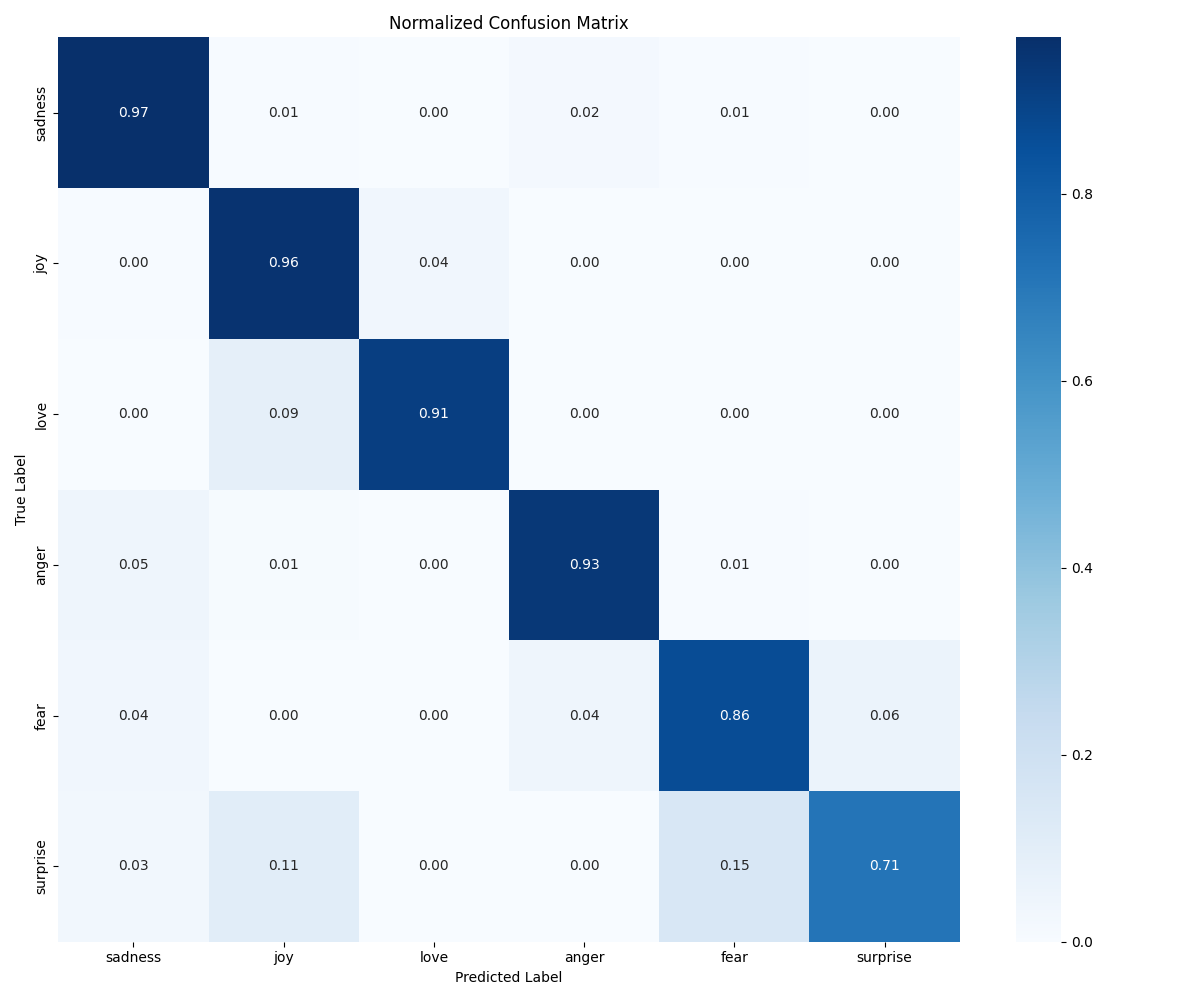
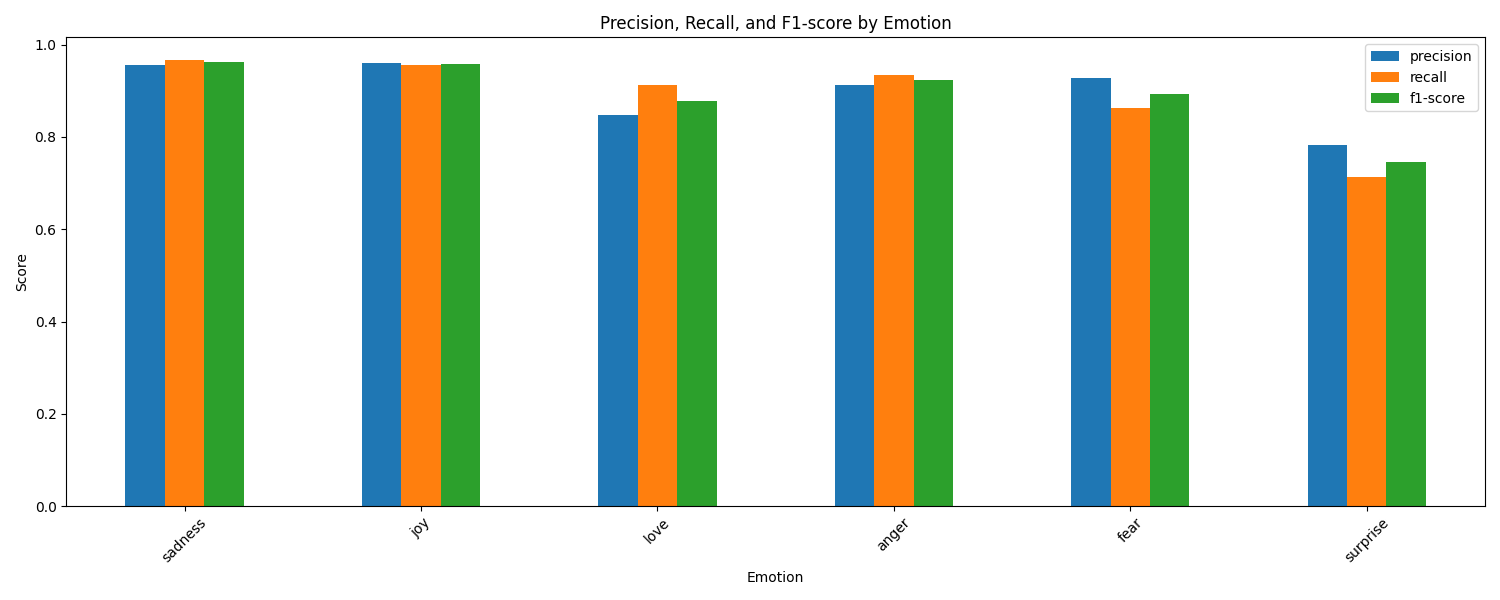
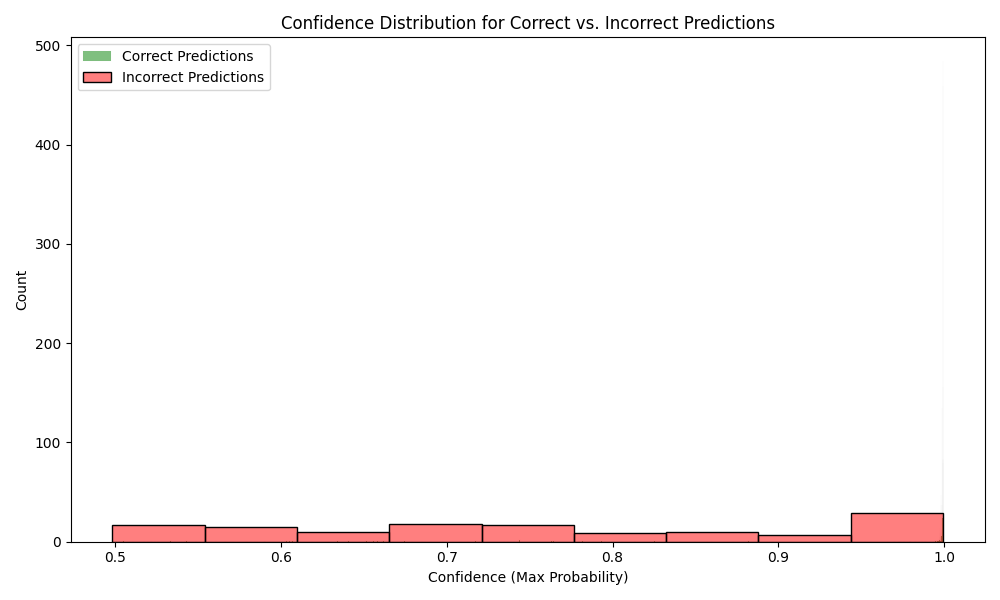
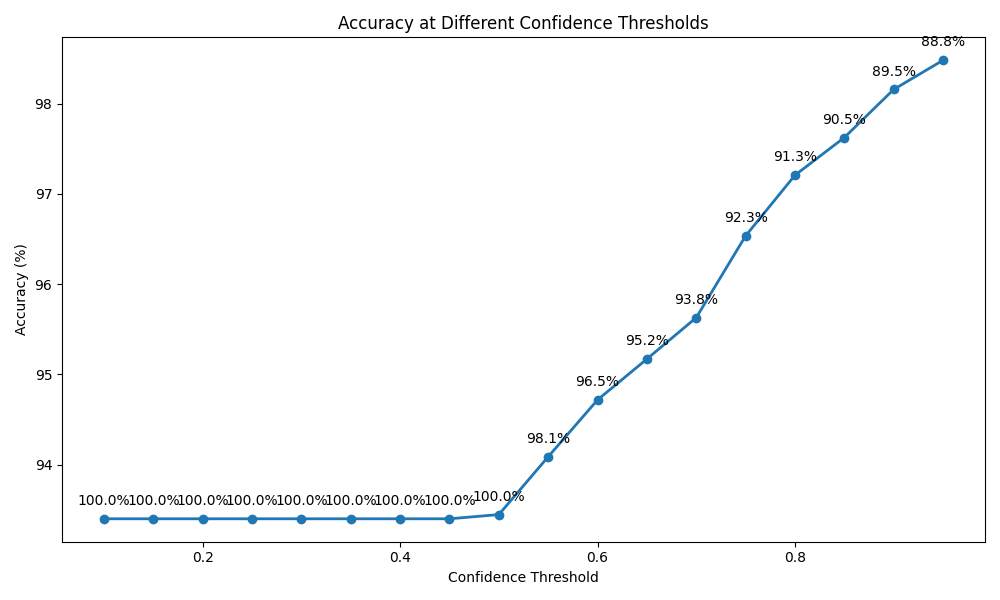

In [ ]:
import base64
from IPython.display import HTML, display
import os

def display_report_in_notebook():
    """Display model analysis report directly in the notebook"""

    # Helper function to encode images as base64
    def get_image_base64(image_path):
        if os.path.exists(image_path):
            with open(image_path, "rb") as image_file:
                return base64.b64encode(image_file.read()).decode('utf-8')
        return None

    # Load report data
    try:
        class_report = pd.read_csv(f"{analysis_dir}/classification_report.csv")

        # Try to load confusion pairs, use empty DataFrame if it doesn't exist
        try:
            confusion_pairs = pd.read_csv(f"{analysis_dir}/confusion_pairs.csv")
        except:
            confusion_pairs = pd.DataFrame(columns=['true', 'predicted', 'count', 'percent'])

        # Load main metrics
        accuracy = class_report.loc[class_report['Unnamed: 0'] == 'accuracy', 'f1-score'].values[0]
        weighted_f1 = class_report.loc[class_report['Unnamed: 0'] == 'weighted avg', 'f1-score'].values[0]

        # Get best/worst emotions
        sorted_emotions = class_report.iloc[:len(emotion_labels)].sort_values('f1-score', ascending=False)
        best_emotion1 = sorted_emotions['Unnamed: 0'].values[0]
        best_f1_1 = sorted_emotions['f1-score'].values[0]
        best_emotion2 = sorted_emotions['Unnamed: 0'].values[1]
        best_f1_2 = sorted_emotions['f1-score'].values[1]

        worst_emotion1 = sorted_emotions['Unnamed: 0'].values[-1]
        worst_f1_1 = sorted_emotions['f1-score'].values[-1]
        worst_emotion2 = sorted_emotions['Unnamed: 0'].values[-2]
        worst_f1_2 = sorted_emotions['f1-score'].values[-2]

        # Create HTML for report
        html = f"""
        <div style="font-family: Arial, sans-serif; max-width: 1000px; margin: 0 auto; padding: 20px;">
            <h1 style="color: #2C3E50;">Emotion Classification Model Analysis</h1>

            <div style="border: 1px solid #ddd; border-radius: 8px; padding: 20px; margin-bottom: 30px; background-color: #f9f9f9;">
                <h2 style="color: #2C3E50;">Executive Summary</h2>
                <div style="background-color: #E8F5E9; padding: 15px; border-left: 5px solid #4CAF50; border-radius: 4px;">
                    <p>This analysis examines a RoBERTa-based emotion classification model trained on the dair-ai/emotion dataset.
                    The model achieves an overall accuracy of <b>{accuracy:.4f}</b> on the test set.</p>

                    <p>The model performs best on emotions like <b>{best_emotion1}</b> (F1: {best_f1_1:.3f})
                    and <b>{best_emotion2}</b> (F1: {best_f1_2:.3f}), while struggling more with
                    <b>{worst_emotion1}</b> (F1: {worst_f1_1:.3f}) and <b>{worst_emotion2}</b> (F1: {worst_f1_2:.3f}).</p>
                </div>
            </div>

            <div style="border: 1px solid #ddd; border-radius: 8px; padding: 20px; margin-bottom: 30px; background-color: #f9f9f9;">
                <h2 style="color: #2C3E50;">Performance by Emotion</h2>
                <table style="border-collapse: collapse; width: 100%; margin-bottom: 20px;">
                    <tr style="background-color: #4CAF50; color: white;">
                        <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Emotion</th>
                        <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Precision</th>
                        <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Recall</th>
                        <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">F1-Score</th>
                        <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Support</th>
                    </tr>
        """

        # Add rows for each emotion
        for i, row in class_report.iloc[:len(emotion_labels)].iterrows():
            emotion = row['Unnamed: 0']
            precision = row['precision']
            recall = row['recall']
            f1 = row['f1-score']
            support = row['support']
            bg_color = "#f2f2f2" if i % 2 == 0 else "white"

            html += f"""
                    <tr style="background-color: {bg_color};">
                        <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{emotion}</td>
                        <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{precision:.3f}</td>
                        <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{recall:.3f}</td>
                        <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{f1:.3f}</td>
                        <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{support}</td>
                    </tr>
            """

        # Add summary rows
        for i, row in class_report.iloc[len(emotion_labels):].iterrows():
            metric = row['Unnamed: 0']
            if metric in ['accuracy', 'macro avg', 'weighted avg']:
                precision = row['precision'] if not pd.isna(row['precision']) else "-"
                recall = row['recall'] if not pd.isna(row['recall']) else "-"
                f1 = row['f1-score']
                support = row['support']

                html += f"""
                        <tr style="background-color: #e8f5e9; font-weight: bold;">
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{metric}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{precision if isinstance(precision, str) else precision:.3f}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{recall if isinstance(recall, str) else recall:.3f}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{f1:.3f}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{support}</td>
                        </tr>
                """

        html += """
                </table>
            </div>
        """

        # Add visualizations section
        html += """
            <div style="border: 1px solid #ddd; border-radius: 8px; padding: 20px; margin-bottom: 30px; background-color: #f9f9f9;">
                <h2 style="color: #2C3E50;">Visualizations</h2>
                <div style="display: flex; flex-wrap: wrap; gap: 20px; justify-content: center;">
        """

        # Add confusion matrix if it exists
        confusion_matrix_img = get_image_base64(f"{analysis_dir}/confusion_matrix.png")
        if confusion_matrix_img:
            html += f"""
                    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1); width: 45%;">
                        <h3 style="margin-top: 0; color: #2C3E50; text-align: center;">Confusion Matrix</h3>
                        <img src="data:image/png;base64,{confusion_matrix_img}" style="max-width: 100%; height: auto; border-radius: 4px;">
                    </div>
            """

        # Add per-class metrics if it exists
        per_class_metrics_img = get_image_base64(f"{analysis_dir}/per_class_metrics.png")
        if per_class_metrics_img:
            html += f"""
                    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1); width: 45%;">
                        <h3 style="margin-top: 0; color: #2C3E50; text-align: center;">Per-class Metrics</h3>
                        <img src="data:image/png;base64,{per_class_metrics_img}" style="max-width: 100%; height: auto; border-radius: 4px;">
                    </div>
            """

        # Add confidence distribution if it exists
        confidence_dist_img = get_image_base64(f"{analysis_dir}/confidence_distribution.png")
        if confidence_dist_img:
            html += f"""
                    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1); width: 45%;">
                        <h3 style="margin-top: 0; color: #2C3E50; text-align: center;">Confidence Distribution</h3>
                        <img src="data:image/png;base64,{confidence_dist_img}" style="max-width: 100%; height: auto; border-radius: 4px;">
                    </div>
            """

        # Add accuracy vs threshold if it exists
        acc_threshold_img = get_image_base64(f"{analysis_dir}/accuracy_vs_threshold.png")
        if acc_threshold_img:
            html += f"""
                    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1); width: 45%;">
                        <h3 style="margin-top: 0; color: #2C3E50; text-align: center;">Accuracy vs Threshold</h3>
                        <img src="data:image/png;base64,{acc_threshold_img}" style="max-width: 100%; height: auto; border-radius: 4px;">
                    </div>
            """

        # Add length analysis if it exists
        length_img = get_image_base64(f"{analysis_dir}/accuracy_by_length.png")
        if length_img:
            html += f"""
                    <div style="border: 1px solid #ddd; border-radius: 8px; padding: 10px; background-color: white; box-shadow: 0 4px 8px rgba(0,0,0,0.1); width: 45%;">
                        <h3 style="margin-top: 0; color: #2C3E50; text-align: center;">Accuracy by Text Length</h3>
                        <img src="data:image/png;base64,{length_img}" style="max-width: 100%; height: auto; border-radius: 4px;">
                    </div>
            """

        html += """
                </div>
            </div>
        """

        # Add error analysis if we have confusion pairs
        if not confusion_pairs.empty:
            html += """
                <div style="border: 1px solid #ddd; border-radius: 8px; padding: 20px; margin-bottom: 30px; background-color: #f9f9f9;">
                    <h2 style="color: #2C3E50;">Error Analysis</h2>
                    <h3>Most Common Confusion Pairs</h3>
                    <table style="border-collapse: collapse; width: 100%; margin-bottom: 20px;">
                        <tr style="background-color: #4CAF50; color: white;">
                            <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">True Emotion</th>
                            <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Predicted Emotion</th>
                            <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Count</th>
                            <th style="padding: 12px 8px; text-align: left; border: 1px solid #ddd;">Percentage</th>
                        </tr>
            """

            # Add rows for top confusion pairs
            for i, row in confusion_pairs.head(10).iterrows():
                bg_color = "#f2f2f2" if i % 2 == 0 else "white"
                html += f"""
                        <tr style="background-color: {bg_color};">
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{row['true']}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{row['predicted']}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{row['count']}</td>
                            <td style="padding: 8px; text-align: left; border: 1px solid #ddd;">{row['percent']:.2f}%</td>
                        </tr>
                """

            html += """
                    </table>
                </div>
            """

        # Add recommendations section
        html += f"""
            <div style="border: 1px solid #ddd; border-radius: 8px; padding: 20px; margin-bottom: 30px; background-color: #f9f9f9;">
                <h2 style="color: #2C3E50;">Conclusions and Recommendations</h2>
                <div style="background-color: #E8F5E9; padding: 15px; border-left: 5px solid #4CAF50; border-radius: 4px;">
                    <h3>Key Findings</h3>
                    <ul>
                        <li>The model achieves an overall accuracy of <b>{accuracy:.4f}</b> and a weighted F1-score of <b>{weighted_f1:.4f}</b>.</li>
                        <li>Performance varies significantly across emotions, with the best F1-scores for <b>{best_emotion1}</b> ({best_f1_1:.3f}) and <b>{best_emotion2}</b> ({best_f1_2:.3f}).</li>
                        <li>Emotions with the worst performance are <b>{worst_emotion1}</b> ({worst_f1_1:.3f}) and <b>{worst_emotion2}</b> ({worst_f1_2:.3f}).</li>
                    """

        # Add confusion pair info if available
        if not confusion_pairs.empty and len(confusion_pairs) >= 2:
            html += f"""
                        <li>Certain emotion pairs are frequently confused, particularly <b>{confusion_pairs['true'].values[0]}</b> with <b>{confusion_pairs['predicted'].values[0]}</b> and
                        <b>{confusion_pairs['true'].values[1]}</b> with <b>{confusion_pairs['predicted'].values[1]}</b>.</li>
            """

        html += """
                    </ul>

                    <h3>Recommendations for Improvement</h3>
                    <ul>
                        <li>Collect more training examples for the emotions with lower performance.</li>
                        <li>Consider using a confidence threshold to improve precision for critical applications.</li>
                        <li>Experiment with data augmentation techniques for underrepresented emotions.</li>
                        <li>Use oversampling or weighting strategies to address class imbalance.</li>
                        <li>Consider a hierarchical classification approach for similar emotions.</li>
                    </ul>
                </div>
            </div>

            <footer style="text-align: center; margin-top: 30px; color: #7f8c8d; font-size: 0.9em;">
                <p>Report generated on """

        html += f"{pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}</p>"
        html += """
            </footer>
        </div>
        """

        # Return HTML
        return HTML(html)

    except Exception as e:
        # Error handling
        error_html = f"""
        <div style="padding: 20px; background-color: #ffebee; border-left: 5px solid #f44336; margin-bottom: 15px;">
            <h2>Error Generating Report</h2>
            <p>There was an error generating the report: {str(e)}</p>
            <p>Check if all required analysis files exist in the "{analysis_dir}" directory.</p>
        </div>
        """
        return HTML(error_html)

# Display the report
display_report_in_notebook()

In [ ]:
import os
import shutil
from google.colab import files

# Path to your model_analysis directory
analysis_dir = "model_analysis"  # Change this if your directory has a different name

# Check if directory exists
if os.path.exists(analysis_dir):
    # Create a zip file of the entire directory
    zip_filename = f"{analysis_dir}.zip"
    shutil.make_archive(analysis_dir, 'zip', analysis_dir)

    # Download the zip file
    files.download(zip_filename)
    print(f"Download of {zip_filename} should start automatically.")
else:
    print(f"Error: The directory '{analysis_dir}' doesn't exist.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Download of model_analysis.zip should start automatically.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
import seaborn as sns

def analyze_performance_breakpoints():
    """Analyze at which points model performance changes significantly based on text properties"""

    # Make sure we have word counts
    if 'word_count' not in results_df.columns:
        results_df['word_count'] = results_df['text'].apply(lambda x: len(str(x).split()))

    print("Analyzing performance by text length...")

    # Calculate moving average accuracy by word count
    # Group by word count and calculate accuracy
    word_count_performance = results_df.groupby('word_count')['correct'].agg(['mean', 'count']).reset_index()
    word_count_performance.columns = ['word_count', 'accuracy', 'sample_count']

    # Filter to only include word counts with enough samples (at least 5)
    min_samples = 5
    filtered_counts = word_count_performance[word_count_performance['sample_count'] >= min_samples]

    # Create detailed plot
    plt.figure(figsize=(14, 8))

    # Scatter plot with size based on sample count
    plt.scatter(
        filtered_counts['word_count'],
        filtered_counts['accuracy'],
        s=filtered_counts['sample_count'] * 2,  # Size based on sample count
        alpha=0.6,
        c=filtered_counts['accuracy'],  # Color based on accuracy
        cmap='RdYlGn'
    )

    # Add smoothed trend line if we have enough data points
    if len(filtered_counts) > 5:
        try:
            # Sort by word count
            sorted_data = filtered_counts.sort_values('word_count')

            # Create smooth curve
            x = sorted_data['word_count']
            y = sorted_data['accuracy']

            # Use smoothing spline
            if len(x) > 3:  # Need at least 4 points for cubic spline
                x_smooth = np.linspace(x.min(), x.max(), 100)
                spl = make_interp_spline(x, y, k=3)  # k=3 for cubic spline
                y_smooth = spl(x_smooth)
                plt.plot(x_smooth, y_smooth, 'r-', linewidth=2)
            else:
                # Use simple line if not enough points
                plt.plot(x, y, 'r-', linewidth=2)

        except Exception as e:
            print(f"Couldn't create smoothed trend line: {e}")
            # Fallback to simple line
            plt.plot(
                filtered_counts['word_count'],
                filtered_counts['accuracy'],
                'r-', linewidth=2
            )

    # Find where accuracy peaks and drops
    if len(filtered_counts) > 0:
        # Find peak accuracy
        max_accuracy = filtered_counts.loc[filtered_counts['accuracy'].idxmax()]
        plt.axvline(x=max_accuracy['word_count'], color='green', linestyle='--', alpha=0.5)
        plt.text(
            max_accuracy['word_count'] + 0.5,
            0.5,
            f"Peak accuracy at {max_accuracy['word_count']} words: {max_accuracy['accuracy']:.3f}",
            rotation=90, verticalalignment='center'
        )

        # Find significant drops (if accuracy drops by more than 10% from peak)
        drop_threshold = max_accuracy['accuracy'] - 0.1
        drops = filtered_counts[
            (filtered_counts['word_count'] > max_accuracy['word_count']) &
            (filtered_counts['accuracy'] < drop_threshold)
        ]

        if len(drops) > 0:
            first_drop = drops.iloc[0]
            plt.axvline(x=first_drop['word_count'], color='red', linestyle='--', alpha=0.5)
            plt.text(
                first_drop['word_count'] + 0.5,
                0.5,
                f"Performance drop at {first_drop['word_count']} words: {first_drop['accuracy']:.3f}",
                rotation=90, verticalalignment='center'
            )

    plt.xlabel('Word Count')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy by Word Count')
    plt.grid(True, alpha=0.3)

    # Add color bar to indicate accuracy levels
    cbar = plt.colorbar()
    cbar.set_label('Accuracy')

    # Add annotation for bubble size
    plt.text(
        0.05, 0.05,
        f'Bubble size represents sample count\nOnly showing word counts with {min_samples}+ samples',
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8)
    )

    plt.tight_layout()
    plt.savefig(f"{analysis_dir}/word_count_performance_detailed.png")
    plt.close()

    # Calculate detailed statistics
    print("\nDetailed performance analysis by word count:")
    print(f"- Peak accuracy: {max_accuracy['accuracy']:.3f} at {max_accuracy['word_count']} words")

    # Calculate performance ranges
    ranges = [
        (1, 5, "Very short (1-5 words)"),
        (6, 10, "Short (6-10 words)"),
        (11, 20, "Medium (11-20 words)"),
        (21, 30, "Medium-long (21-30 words)"),
        (31, 50, "Long (31-50 words)"),
        (51, 100, "Very long (51-100 words)"),
        (101, 9999, "Extremely long (101+ words)")
    ]

    range_stats = []
    for start, end, label in ranges:
        mask = (results_df['word_count'] >= start) & (results_df['word_count'] <= end)
        count = mask.sum()
        if count > 0:
            accuracy = results_df.loc[mask, 'correct'].mean()
            range_stats.append({
                'range': label,
                'start': start,
                'end': end,
                'count': count,
                'accuracy': accuracy
            })

    range_df = pd.DataFrame(range_stats)
    print("\nPerformance by text length ranges:")
    for _, row in range_df.iterrows():
        print(f"- {row['range']}: {row['accuracy']:.3f} accuracy ({row['count']} samples)")

    # Save range stats
    range_df.to_csv(f"{analysis_dir}/word_count_range_performance.csv", index=False)

    # Analyze by confidence threshold
    print("\nAnalyzing performance by confidence threshold...")

    if 'confidence' in results_df.columns:
        # Create confidence threshold analysis
        thresholds = np.arange(0.5, 1.0, 0.05)
        threshold_stats = []

        for threshold in thresholds:
            # Count samples above threshold
            above_threshold = results_df['confidence'] >= threshold
            count = above_threshold.sum()

            if count > 0:
                # Calculate accuracy for samples above threshold
                accuracy = results_df.loc[above_threshold, 'correct'].mean()
                coverage = count / len(results_df) * 100

                threshold_stats.append({
                    'threshold': threshold,
                    'accuracy': accuracy,
                    'coverage': coverage,
                    'count': count
                })

        threshold_df = pd.DataFrame(threshold_stats)

        # Plot threshold analysis
        plt.figure(figsize=(12, 6))

        # Create primary y-axis for accuracy
        ax1 = plt.gca()
        ax1.set_xlabel('Confidence Threshold')
        ax1.set_ylabel('Accuracy', color='blue')
        ax1.plot(threshold_df['threshold'], threshold_df['accuracy'], 'b-', marker='o')
        ax1.tick_params(axis='y', labelcolor='blue')

        # Create secondary y-axis for coverage
        ax2 = ax1.twinx()
        ax2.set_ylabel('Coverage (%)', color='red')
        ax2.plot(threshold_df['threshold'], threshold_df['coverage'], 'r-', marker='s')
        ax2.tick_params(axis='y', labelcolor='red')

        plt.title('Accuracy and Coverage by Confidence Threshold')
        plt.grid(True, alpha=0.3)

        # Add legend
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, ['Accuracy', 'Coverage'], loc='upper center')

        # Annotate optimal threshold
        # Find threshold with highest accuracy while maintaining at least 50% coverage
        high_coverage = threshold_df[threshold_df['coverage'] >= 50]
        if len(high_coverage) > 0:
            optimal = high_coverage.loc[high_coverage['accuracy'].idxmax()]
            plt.axvline(x=optimal['threshold'], color='green', linestyle='--', alpha=0.5)
            plt.text(
                optimal['threshold'] + 0.01,
                ax1.get_ylim()[0] + 0.1,
                f"Optimal threshold: {optimal['threshold']:.2f}\nAccuracy: {optimal['accuracy']:.3f}\nCoverage: {optimal['coverage']:.1f}%",
                bbox=dict(facecolor='white', alpha=0.8)
            )

        plt.tight_layout()
        plt.savefig(f"{analysis_dir}/confidence_threshold_analysis.png")
        plt.close()

        # Print optimal threshold info
        if len(high_coverage) > 0:
            print(f"\nOptimal confidence threshold: {optimal['threshold']:.2f}")
            print(f"- Accuracy at this threshold: {optimal['accuracy']:.3f}")
            print(f"- Coverage at this threshold: {optimal['coverage']:.1f}%")

        # Save threshold stats
        threshold_df.to_csv(f"{analysis_dir}/confidence_threshold_stats.csv", index=False)

    else:
        print("Confidence values not available in results.")

    # Return summary of findings
    findings = {
        "word_count_ranges": range_df,
        "optimal_word_count": max_accuracy['word_count'] if 'max_accuracy' in locals() else None,
        "confidence_thresholds": threshold_df if 'threshold_df' in locals() else None
    }

    return findings

# Run the analysis
performance_breakpoints = analyze_performance_breakpoints()
print("\nAnalysis complete. Results saved to analysis directory.")

Analyzing performance by text length...

Detailed performance analysis by word count:
- Peak accuracy: 1.000 at 29.0 words

Performance by text length ranges:
- Very short (1-5 words): 0.957 accuracy (92 samples)
- Short (6-10 words): 0.941 accuracy (409 samples)
- Medium (11-20 words): 0.931 accuracy (729 samples)
- Medium-long (21-30 words): 0.930 accuracy (460 samples)
- Long (31-50 words): 0.934 accuracy (287 samples)
- Very long (51-100 words): 0.870 accuracy (23 samples)

Analyzing performance by confidence threshold...

Optimal confidence threshold: 0.95
- Accuracy at this threshold: 0.985
- Coverage at this threshold: 88.8%

Analysis complete. Results saved to analysis directory.
